In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import pandas as pd
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit

import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import date
import pandas_datareader as pdr
import yfinance as yf
import pandas as pd
from datetime import date
import pandas_datareader as pdr
#Importing basic libraries.
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings("ignore")

#Pandas setting for better visualization of dataframe.
pd.options.display.float_format='{:.2f}'.format
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format


pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:

def get_financial_statements(ticker_name, start_date, end_date, frequency):
    ticker = yf.Ticker(ticker_name)
    dataframes = []

    # Get balance sheet
    balance_sheet = ticker.balance_sheet
    balance_sheet = balance_sheet.replace(0, np.nan)
    balance_sheet.fillna(balance_sheet.mean(), inplace=True)
    dataframes.append(balance_sheet)

    # Get income statement
    income_statement = ticker.financials
    income_statement = income_statement.replace(0, np.nan)
    income_statement.fillna(income_statement.mean(), inplace=True)
    dataframes.append(income_statement)

    # Get cashflow statement
    cashflow_statement = ticker.cashflow
    cashflow_statement = cashflow_statement.replace(0, np.nan)
    cashflow_statement.fillna(cashflow_statement.mean(), inplace=True)
    dataframes.append(cashflow_statement)

    # Combine and reshape the dataframes
    combined_data = pd.concat(dataframes, axis=0)
    combined_data = combined_data.T

    return combined_data

ticker_name = "IBM"
start_date = pd.to_datetime("2010-07-01")
end_date = pd.to_datetime("2023-07-31")
frequency = "1d"

financial_statements = get_financial_statements(ticker_name, start_date, end_date, frequency)
financial_statements.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4 entries, 2022-12-31 to 2019-12-31
Columns: 213 entries, Treasury Shares Number to Net Income From Continuing Operations
dtypes: float64(213)
memory usage: 6.9 KB


In [ ]:
df=financial_statements

In [ ]:
import pandas as pd

def compute_ratios(df):
    df['PE_Ratio'] = df['Net Income'] / df['Ordinary Shares Number']
    df['Debt_to_Equity_Ratio'] = df['Total Debt'] / df['Stockholders Equity']
    df['Current_Ratio'] = df['Current Assets'] / df['Current Liabilities']
    df['Quick_Ratio'] = (df['Current Assets'] - df['Inventory']) / df['Current Liabilities']
    df['ROE'] = df['Net Income'] / df['Stockholders Equity']
    df['ROA'] = df['Net Income'] / df['Total Assets']
    df['Working_Capital_Ratio'] = df['Current Assets'] / df['Current Liabilities']
    df['Gross_Margin_Ratio'] = df['Gross Profit'] / df['Total Revenue']
    df['Operating_Margin_Ratio'] = df['Operating Income'] / df['Total Revenue']
    df['Net_Profit_Margin'] = df['Net Income'] / df['Total Revenue']
    df['Cash_Ratio'] = (df['Cash And Cash Equivalents'] + df['Other Short Term Investments']) / df['Current Liabilities']
    df['Inventory_Turnover_Ratio'] = df['Cost Of Revenue'] / df['Inventory']
    df['Accounts_Receivable_Turnover_Ratio'] = df['Total Revenue'] / df['Accounts Receivable']
    df['EPS'] = df['Net Income'] / df['Ordinary Shares Number']

    # Additional ratios
    df['Asset_Turnover_Ratio'] = df['Total Revenue'] / df['Total Assets']
    df['Interest_Coverage_Ratio'] = df['Operating Income'] / df['Interest Expense']
    df['Return_on_Investment'] = df['Net Income'] / (df['Total Assets'] - df['Current Liabilities'])

    # Bring the newly computed ratio columns to the front of the dataframe
    cols = df.columns.tolist()
    ratio_cols = [col for col in cols if '_Ratio' in col or col in ['ROE', 'ROA', 'EPS', 'Return_on_Investment']]
    non_ratio_cols = [col for col in cols if col not in ratio_cols]
    df = df[ratio_cols + non_ratio_cols]

    return df
df=compute_ratios(df)
df

KeyError: ignored

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

def get_ratios(ticker_names):
    ratios_dataframes = []

    for ticker_name in ticker_names:
        try:
            ticker = yf.Ticker(ticker_name)
            dataframes = []

            # Get balance sheet
            balance_sheet = ticker.balance_sheet
            if balance_sheet is not None:
                balance_sheet = balance_sheet.replace(0, np.nan).fillna(balance_sheet.mean())
                dataframes.append(balance_sheet)

            # Get income statement
            income_statement = ticker.financials
            if income_statement is not None:
                income_statement = income_statement.replace(0, np.nan).fillna(income_statement.mean())
                dataframes.append(income_statement)

            # Get cashflow statement
            cashflow_statement = ticker.cashflow
            if cashflow_statement is not None:
                cashflow_statement = cashflow_statement.replace(0, np.nan).fillna(cashflow_statement.mean())
                dataframes.append(cashflow_statement)

            # Combine and reshape the dataframes
            df = pd.concat(dataframes, axis=0).T

            # Compute ratios
            for ratio_name, ratio_formula in {
                'PE_Ratio': ('Net Income', 'Ordinary Shares Number'),
                'Debt_to_Equity_Ratio': ('Total Debt', 'Stockholders Equity'),
                'Current_Ratio': ('Current Assets', 'Current Liabilities'),
                'Quick_Ratio': ('Current Assets', 'Inventory', 'Current Liabilities'),
                'ROE': ('Net Income', 'Stockholders Equity'),
                'ROA': ('Net Income', 'Total Assets'),
                'Working_Capital_Ratio': ('Current Assets', 'Current Liabilities'),
                'Gross_Margin_Ratio': ('Gross Profit', 'Total Revenue'),
                'Operating_Margin_Ratio': ('Operating Income', 'Total Revenue'),
                'Net_Profit_Margin': ('Net Income', 'Total Revenue'),
                'Cash_Ratio': ('Cash And Cash Equivalents', 'Other Short Term Investments', 'Current Liabilities'),
                'Inventory_Turnover_Ratio': ('Cost Of Revenue', 'Inventory'),
                'Accounts_Receivable_Turnover_Ratio': ('Total Revenue', 'Accounts Receivable'),
                'EPS': ('Net Income', 'Ordinary Shares Number'),
                'Asset_Turnover_Ratio': ('Total Revenue', 'Total Assets'),
                'Interest_Coverage_Ratio': ('Operating Income', 'Interest Expense'),
                'Return_on_Investment': ('Net Income', 'Total Assets', 'Current Liabilities')
            }.items():
                try:
                    if len(ratio_formula) == 2:
                        df[ratio_name] = df[ratio_formula[0]] / df[ratio_formula[1]]
                    elif len(ratio_formula) == 3:
                        df[ratio_name] = (df[ratio_formula[0]] - df.get(ratio_formula[1], 0)) / df[ratio_formula[2]]
                except KeyError:
                    df[ratio_name] = np.nan

            # Retain only ratio columns
            df = df[[c for c in df.columns if '_Ratio' in c or c in ['ROE', 'ROA', 'EPS', 'Return_on_Investment']]]

            ratios_dataframes.append(df)
        except Exception as e:
            print(f"Failed to process {ticker_name}: {str(e)}")

    return ratios_dataframes



In [ ]:
most_important_columns = [
    "Total Assets",
    "Total Equity Gross Minority Interest",
    "Total Liabilities Net Minority Interest",
    "Net Tangible Assets",
    "Stockholders Equity",
    "Total Debt",
    "Net Debt",
    "Working Capital",
    "Invested Capital",
    "Common Stock Equity",
    "Tangible Book Value",
    "Total Capitalization",
    "Treasury Shares Number",
    "Ordinary Shares Number",
    "Share Issued",
    "Capital Lease Obligations",
    "Minority Interest",
    "Retained Earnings",
    "Total Non Current Liabilities Net Minority Interest",
    "Long Term Debt",
    "Current Liabilities",
    "Current Debt",
    "Cash And Cash Equivalents",
    "Net Income",
    "Operating Income",
    "Gross Profit",
    "Operating Revenue",
    "Cost Of Revenue",
    "Net Income From Continuing Operations"
]
moderately_important_columns = [
    "Long Term Provisions",
    "Other Non Current Liabilities",
    "Other Current Liabilities",
    "Other Equity Adjustments",
    "Other Non Current Assets",
    "Other Current Assets",
    "Property, Plant, and Equipment (PPE)",
    "Intangible Assets",
    "Goodwill",
    "Research and Development Expenses",
    "Selling, General, and Administrative Expenses",
    "Interest Expense",
    "Interest Income",
    "Income Tax Expense",
    "Net Income Available to Common Stockholders",
    "Earnings per Share (EPS)",
    "Dividends",
    "Return on Equity (ROE)",
    "Return on Assets (ROA)",
    "Debt to Equity Ratio",
    "Current Ratio",
    "Quick Ratio",
    "Inventory Turnover",
    "Accounts Receivable Turnover",
    "Days Sales Outstanding (DSO)",
    "Fixed Asset Turnover",
    "Profit Margin",
    "Operating Margin",
    "Return on Investment (ROI)"
]
less_important_columns = [
    "Accumulated Depreciation",
    "Deferred Revenue",
    "Deferred Tax Assets",
    "Deferred Tax Liabilities",
    "Long-Term Investments",
    "Short-Term Investments",
    "Accounts Payable",
    "Accrued Expenses",
    "Other Income/Expenses",
    "Share Buybacks",
    "Net Cash Flow from Operations",
    "Net Cash Flow from Investing Activities",
    "Net Cash Flow from Financing Activities",
    "Free Cash Flow",
    "Capital Expenditures",
    "Earnings Before Interest, Taxes, Depreciation, and Amortization (EBITDA)",
    "Price-to-Earnings Ratio (P/E)",
    "Price-to-Book Ratio (P/B)",
    "Dividend Yield",
    "Market Capitalization",
    "Book Value per Share",
    "Economic Value Added (EVA)",
    "Market Share",
    "Brand Value",
    "Customer Satisfaction Index",
    "Employee Turnover Rate",
    "Working Capital Turnover",
    "Return on Investment Capital (ROIC)",
    "Gross Domestic Product (GDP)",
    "Consumer Price Index (CPI)",
    "Unemployment Rate",
    "Interest Rates",
    "Inflation Rate"
]
least_important_columns = [
    "Normalized Income",
    "Other Comprehensive Income",
    "Pension and Employee Benefit Expense",
    "Amortization of Intangible Assets",
    "Impairment Charges",
    "Restructuring Charges",
    "Litigation Expenses",
    "Foreign Exchange Gains/Losses",
    "Non-Operating Income/Expenses",
    "Stock-Based Compensation",
    "Goodwill Impairment",
    "Asset Write-Offs",
    "Tax Rate",
    "R&D as a Percentage of Revenue",
    "SG&A as a Percentage of Revenue",
    "Interest Coverage Ratio",
    "Inventory to Sales Ratio",
    "Fixed Charge Coverage Ratio",
    "Cash Conversion Cycle",
    "Net Promoter Score (NPS)",
    "Social Media Engagement",
    "Environmental, Social, and Governance (ESG) Metrics",
    "Corporate Social Responsibility (CSR) Initiatives",
    "Industry-Specific Key Performance Indicators (KPIs)",
    "Regulatory Compliance",
    "Technology Adoption",
    "Customer Acquisition Cost (CAC)",
    "Lifetime Value (LTV) of a Customer",
    "Net Promoter Score (NPS)",
    "Churn Rate"
]

In [ ]:

ticker_names_technology = ["IBM", "AAPL", "GOOGL", "MSFT", "AMZN", "FB", "INTC", "CSCO", "NVDA", "ORCL"]
ticker_names_finance = ["JPM", "BAC", "GS", "C", "WFC", "AXP", "MS", "BLK", "SPGI", "PNC"]
ticker_names_healthcare = ["JNJ", "PFE", "UNH", "MRK", "ABT", "TMO", "CVS", "MDT", "LLY", "AMGN"]
ticker_names_energy = ["XOM", "CVX", "RDS.A", "TOT", "BP", "COP", "SLB", "EQT", "PXD", "EOG"]
ticker_names_retail = ["WMT", "TGT", "COST", "HD", "MCD", "NKE", "ULTA", "LOW", "BBY", "CVS"]
ticker_names_automotive = ["TM", "F", "GM", "HMC", "VLKAF", "TSLA", "BMWYY", "DDAIF", "HYMTF", "RACE"]
ticker_names_telecommunications = ["T", "VZ", "TMUS", "CHL", "ORAN", "AMX", "DTEGF", "BTI", "TU", "VOD"]
ticker_names_pharmaceuticals = ["GSK", "SNY", "NVS", "AZN", "LLY", "BMY", "ABBV", "GILD", "MRNA", "PFE"]
ticker_names_airlines = ["AAL", "DAL", "UAL", "LUV", "BA", "EADSY", "RYAAY", "AFRAF", "LHA", "JBLU"]
ticker_names_entertainment = ["DIS", "NFLX", "CMCSA", "TME", "SNE", "LGF.A", "VIAC", "ROKU", "AMC", "MSGN"]
ticker_names_pharma_distribution = ["ABC", "MCK", "CAH", "HSIC", "PBH", "OMI", "PDCO", "HSY", "OXM", "RGR"]
ticker_names_aviation = ["BA", "LUV", "DAL", "UAL", "EADSY", "RYAAY", "AFRAF", "LHA", "JBLU", "AC"]
ticker_names_construction = ["ACM", "FLR", "JEC", "KBR", "MTRN", "PWR", "J", "GVA", "FWLT", "DY"]
ticker_names_food_and_beverage = ["KO", "PEP", "MNST", "KHC", "GIS", "CPB", "STZ", "WBA", "HRL", "CAG"]
ticker_names_gaming = ["ATVI", "EA", "TTWO", "UBSFY", "NTDOY", "NCBDF", "SE", "CDPR", "NVDA", "AMD"]
ticker_names_renewable_energy = ["NEE", "DQ", "ENPH", "SEDG", "FSLR", "PLUG", "BE", "RUN", "SPWR", "REGI"]
ticker_names_telecom_equipment = ["ERIC", "NOK", "ZTCOF", "ADBE", "CRM", "INTU", "NOW", "UBER", "LYFT", "TEAM"]
ticker_names_cosmetics = ["EL", "COTY", "NUS", "IPAR", "REV", "CURLF", "ESTC", "LZB", "ULTA", "SYY"]
ticker_names_logistics = ["UPS", "FDX", "CHRW", "EXPD", "SNDR", "CTVA", "XPO", "LSTR", "JBHT", "HTLD"]
ticker_names_real_estate = ["SPG", "PSA", "PLD", "EQIX", "CBRE", "BXP", "AMT", "ARE", "WELL", "AVB"]



In [ ]:
all_ticker_names = ticker_names_technology + ticker_names_finance + ticker_names_healthcare + ticker_names_energy + ticker_names_retail + ticker_names_automotive + ticker_names_telecommunications + ticker_names_pharmaceuticals + ticker_names_airlines + ticker_names_entertainment + ticker_names_pharma_distribution + ticker_names_aviation + ticker_names_construction + ticker_names_food_and_beverage + ticker_names_gaming + ticker_names_renewable_energy + ticker_names_telecom_equipment + ticker_names_cosmetics + ticker_names_logistics + ticker_names_real_estate


In [ ]:
ticker_names_technology = ["IBM", "AAPL", "GOOGL", "MSFT", "AMZN", "FB", "INTC", "CSCO", "NVDA", "ORCL", "ADBE", "CRM", "TXN", "QCOM", "SAP", "VMW", "ACN", "HPQ", "ADI", "AMAT", "NOW", "CTSH", "WIT", "INFY", "LRCX", "DELL", "SNPS", "MU", "ATVI", "APH", "XLNX"]
ticker_names_finance = ["JPM", "BAC", "GS", "C", "WFC", "AXP", "MS", "BLK", "SPGI", "PNC", "BK", "USB", "MET", "COF", "AIG", "TRV", "SCHW", "PRU", "PGR", "DFS", "AON", "MMC", "MCO", "CME", "ICE", "NTRS", "NDAQ", "CB", "CBOE", "KEY", "FITB"]
ticker_names_healthcare = ["JNJ", "PFE", "UNH", "MRK", "ABT", "TMO", "CVS", "MDT", "LLY", "AMGN", "CI", "SYK", "BDX", "GILD", "ISRG", "DHR", "VRTX", "REGN", "ZTS", "BMY", "HCA", "ANTM", "ILMN", "EW", "VRTX", "BSX", "IDXX", "ALXN", "IQV", "HOLX"]
ticker_names_energy = ["XOM", "CVX", "RDS.A", "TOT", "BP", "COP", "SLB", "EQT", "PXD", "EOG", "OXY", "VLO", "KMI", "PSX", "APC", "APA", "HES", "MPC", "NOV", "DVN", "FTI", "COG", "WMB", "HAL", "CXO", "MRO", "PAA", "CHK", "EOG", "EPD", "ET"]
ticker_names_retail = ["WMT", "TGT", "COST", "HD", "MCD", "NKE", "ULTA", "LOW", "BBY", "CVS", "TJX", "DG", "KR", "ROST", "DLTR", "SBUX", "TSCO", "AZO", "GPC", "TIF", "TJX", "COST", "DLTR", "FL", "TGT", "BBY", "LOW", "KSS", "M", "JWN"]
ticker_names_automotive = ["TM", "F", "GM", "HMC", "VLKAF", "TSLA", "BMWYY", "DDAIF", "HYMTF", "RACE", "POAHF", "DMLRY", "FUJHY", "DDAIY", "NSANY", "RNSDF", "GELYF", "TSLA", "VWAGY", "BAMXF", "HYMTF", "TSLA", "HMC", "NSANY", "VLKAF", "RACE", "GM", "F", "FCAU"]
ticker_names_telecommunications = ["T", "VZ", "TMUS", "CHL", "ORAN", "AMX", "DTEGF", "BTI", "TU", "VOD", "S", "CCI", "AMT", "SBAC", "TMUS", "VZ", "CBB", "DLNK", "TMUS", "IDCC", "ELNK", "GLIBA", "DTEGF", "CNSL", "VG", "DTEGY", "ORAN", "SKM", "LBTYA", "IWSY"]
ticker_names_pharmaceuticals = ["GSK", "SNY", "NVS", "AZN", "LLY", "BMY", "ABBV", "GILD", "MRNA", "PFE", "AMGN", "CELG", "REGN", "VRTX", "NVO", "ZTS", "ALXN", "BIIB", "INCY", "ILMN", "ALNY", "MRK", "JNJ", "RHHBY", "AMGN", "GSK", "ABT", "BMY", "SNY", "ABBV"]
ticker_names_airlines = ["AAL", "DAL", "UAL", "LUV", "BA", "EADSY", "RYAAY", "AFRAF", "LHA", "JBLU", "ALK", "UAL", "SKYW", "CEA", "CPA", "LUV", "RYAAY", "SAVE", "LHA", "EZJ", "AAL", "DLAKF", "AER", "AAL", "VLRS", "DAL", "RJETQ", "RYAAY", "CEA", "JBLU"]
ticker_names_entertainment = ["DIS", "NFLX", "CMCSA", "TME", "SNE", "LGF.A", "VIAC", "ROKU", "AMC", "MSGN", "SPOT", "NWSA", "DISCA", "DISCK", "LIVE", "CNK", "MSGN", "IMAX", "LYV", "NFLX", "LGF.B", "SNE", "VIA", "ROKU", "AMCX", "FWONK", "ISCA", "LBTYA", "MSGN", "VIAB"]
ticker_names_pharma_distribution = ["ABC", "MCK", "CAH", "HSIC", "PBH", "OMI", "PDCO", "HSY", "OXM", "RGR", "CHD", "CAG", "CPB", "HRL", "SJM", "MKC", "GIS", "KHC", "WMT", "K", "TSN", "PEP", "KO", "CCEP", "FIZZ", "BF.B", "STZ", "DPS", "MO", "PM"]
ticker_names_aviation = ["BA", "LUV", "DAL", "UAL", "EADSY", "RYAAY", "AFRAF", "LHA", "JBLU", "AC", "ALK", "CEA", "CATH", "CPA", "EZJ", "AAL", "RYAAY", "DLAKF", "RJETQ", "VLRS"]
ticker_names_construction = ["ACM", "FLR", "JEC", "KBR", "MTRN", "PWR", "J", "GVA", "FWLT", "DY", "TTEK", "JBT", "KBR", "CBI", "DOW", "AEGN", "LII", "MDR", "KMT", "DHI"]
ticker_names_food_and_beverage = ["KO", "PEP", "MNST", "KHC", "GIS", "CPB", "STZ", "WBA", "HRL", "CAG", "MDLZ", "ADM", "TSN", "HAIN", "K", "KDP", "KMB", "HAIN", "RAI", "HSY"]
ticker_names_gaming = ["ATVI", "EA", "TTWO", "UBSFY", "NTDOY", "NCBDF", "SE", "CDPR", "NVDA", "AMD", "ZNGA", "SNY", "CTRP", "SNE", "TCEHY", "ASML", "NCBDF", "NEXOF", "SQNXF", "SGAMY"]
ticker_names_renewable_energy = ["NEE", "DQ", "ENPH", "SEDG", "FSLR", "PLUG", "BE", "RUN", "SPWR", "REGI", "GE", "BEP", "VWSYF", "DNNGY", "XEL", "TERP", "ORA", "EDF", "BEP", "ENB"]
ticker_names_telecom_equipment = ["ERIC", "NOK", "ZTCOF", "ADBE", "CRM", "INTU", "NOW", "UBER", "LYFT", "TEAM", "CTSH", "INFY", "WIT", "DXC", "HPE", "SSNC", "DOX", "EPAM", "PAYC", "AKAM"]
ticker_names_cosmetics = ["EL", "COTY", "NUS", "IPAR", "REV", "CURLF", "ESTC", "LZB", "ULTA", "SYY", "ELF", "COST", "CLX", "TUP", "COTY", "PG", "CHD", "CL", "VFC", "NWL"]
ticker_names_logistics = ["UPS", "FDX", "CHRW", "EXPD", "SNDR", "CTVA", "XPO", "LSTR", "JBHT", "HTLD", "ODFL", "R", "KSU", "GWR", "EXR", "PLD", "WY", "ARE", "PSA", "OHI"]
ticker_names_real_estate = ["SPG", "PSA", "PLD", "EQIX", "CBRE", "BXP", "AMT", "ARE", "WELL", "AVB", "CCI", "DRE", "ESS", "HCFT", "IRM", "AMT", "CONE", "DLR", "MAC", "O"]


In [ ]:
all_ticker_names=ticker_names_technology

In [ ]:
important_columns=[
    "Total Assets",
    "Total Liabilities",
    "Total Equity",
    "Net Income",
    "Gross Profit",
    "Operating Income",
    "EBITDA",
    "Net Debt",
    "Current Assets",
    "Current Liabilities",
    "Cash and Cash Equivalents",
    "Long-Term Debt",
    "Working Capital",
    "Return on Equity",
    "Return on Assets",
    "Debt-to-Equity Ratio",
    "Current Ratio",
    "Quick Ratio",
    "Profit Margin",
    "Earnings per Share",
    "Price-to-Earnings Ratio",
    "Dividend Yield",
    "Tangible Book Value",
    "Invested Capital",
    "Retained Earnings",
    "Total Revenue",
    "Free Cash Flow",
    "EBIT",
    "Net Tangible Assets",
    "Total Debt",
    "Common Stock Equity"
]


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np#i can make it fasster im just lazy

def get_ratios(ticker_names, years=4):
    ratios_dataframes = []

    for ticker_name in ticker_names:
        try:
            ticker = yf.Ticker(ticker_name)
            dataframes = []

            # Get balance sheet
            balance_sheet = ticker.balance_sheet
            if balance_sheet is not None:
                balance_sheet = balance_sheet.iloc[:, :years].replace(0, np.nan).fillna(balance_sheet.mean())
                dataframes.append(balance_sheet)

            # Get income statement
            income_statement = ticker.financials
            if income_statement is not None:
                income_statement = income_statement.iloc[:, :years].replace(0, np.nan).fillna(income_statement.mean())
                dataframes.append(income_statement)

            # Get cashflow statement
            cashflow_statement = ticker.cashflow
            if cashflow_statement is not None:
                cashflow_statement = cashflow_statement.iloc[:, :years].replace(0, np.nan).fillna(cashflow_statement.mean())
                dataframes.append(cashflow_statement)

            # Combine and reshape the dataframes
            df = pd.concat(dataframes, axis=0).T

            # Add ticker_name as a new column
            df['Ticker'] = ticker_name

            # Compute ratios
            for ratio_name, ratio_formula in {
                'PE_Ratio': ('Net Income', 'Ordinary Shares Number'),
                'Debt_to_Equity_Ratio': ('Total Debt', 'Stockholders Equity'),
                'Current_Ratio': ('Current Assets', 'Current Liabilities'),
                'Quick_Ratio': ('Current Assets', 'Inventory', 'Current Liabilities'),
                'ROE': ('Net Income', 'Stockholders Equity'),
                'ROA': ('Net Income', 'Total Assets'),
                'Working_Capital_Ratio': ('Current Assets', 'Current Liabilities'),
                'Gross_Margin_Ratio': ('Gross Profit', 'Total Revenue'),
                'Operating_Margin_Ratio': ('Operating Income', 'Total Revenue'),
                'Net_Profit_Margin': ('Net Income', 'Total Revenue'),
                'Cash_Ratio': ('Cash And Cash Equivalents', 'Other Short Term Investments', 'Current Liabilities'),
                'Inventory_Turnover_Ratio': ('Cost Of Revenue', 'Inventory'),
                'Accounts_Receivable_Turnover_Ratio': ('Total Revenue', 'Accounts Receivable'),
                'EPS': ('Net Income', 'Ordinary Shares Number'),
                'Asset_Turnover_Ratio': ('Total Revenue', 'Total Assets'),
                'Interest_Coverage_Ratio': ('Operating Income', 'Interest Expense'),
                'Return_on_Investment': ('Net Income', 'Total Assets', 'Current Liabilities')
            }.items():
                try:
                    if len(ratio_formula) == 2:
                        df[ratio_name] = df[ratio_formula[0]] / df[ratio_formula[1]]
                    elif len(ratio_formula) == 3:
                        df[ratio_name] = (df[ratio_formula[0]] - df.get(ratio_formula[1], 0)) / df[ratio_formula[2]]
                except KeyError:
                    df[ratio_name] = np.nan

            # Retain only ratio columns and 'Ticker'
            columns_needed=['ROE', 'ROA', 'EPS', 'Return_on_Investment', 'Ticker']+important_columns
            df = df[[c for c in df.columns if '_Ratio' in c or c in columns_needed]]

            ratios_dataframes.append(df.reset_index())
        except Exception as e:
            print(f"Failed to process {ticker_name}: {str(e)}")

    # Combine all dataframes into a single dataframe
    combined_df = pd.concat(ratios_dataframes, ignore_index=True)

    return ratios_dataframes, combined_df


ratios_dataframes,df = get_ratios(all_ticker_names,years=1)


In [ ]:
df=df.dropna()
df

,index,Net Debt,Total Debt,Tangible Book Value,Invested Capital,Working Capital,Net Tangible Assets,Common Stock Equity,Retained Earnings,Current Liabilities,Total Assets,Current Assets,EBIT,Net Income,Operating Income,Gross Profit,Total Revenue,Free Cash Flow,Ticker,PE_Ratio,Debt_to_Equity_Ratio,Current_Ratio,Quick_Ratio,ROE,ROA,Working_Capital_Ratio,Gross_Margin_Ratio,Operating_Margin_Ratio,Cash_Ratio,Inventory_Turnover_Ratio,Accounts_Receivable_Turnover_Ratio,EPS,Asset_Turnover_Ratio,Interest_Coverage_Ratio,Return_on_Investment
0,2022-12-31,43063000000.00,54013000000.00,-45189000000.00,72893000000.00,-2387000000.00,-45189000000.00,21944000000.00,149825000000.00,31505000000.00,127243000000.00,29118000000.00,2372000000.00,1639000000.00,8174000000.00,32687000000.00,60530000000.00,8575000000.00,IBM,1.81,2.46,0.92,0.87,0.07,0.01,0.92,0.54,0.14,0.22,17.94,9.25,1.81,0.48,6.72,-3.99
1,2022-09-30,96423000000.00,120069000000.00,50672000000.00,170741000000.00,-18577000000.00,50672000000.00,50672000000.00,-3068000000.00,153982000000.00,352755000000.00,135405000000.00,119437000000.00,99803000000.00,119437000000.00,170782000000.00,394328000000.00,111443000000.00,AAPL,6.26,2.37,0.88,0.85,1.97,0.28,0.88,0.43,0.30,-0.01,45.20,13.99,6.26,1.12,40.75,-1.64
3,2022-06-30,35850000000.00,61270000000.00,87720000000.00,216323000000.00,74602000000.00,87720000000.00,166542000000.00,84281000000.00,95082000000.00,364840000000.00,169684000000.00,83383000000.00,72738000000.00,83383000000.00,135620000000.00,198270000000.00,65149000000.00,MSFT,9.75,0.37,1.78,1.75,0.44,0.20,1.78,0.68,0.42,-0.81,16.74,4.48,9.75,0.54,40.42,-3.07
4,2022-12-31,13262000000.00,140118000000.00,125755000000.00,213193000000.00,-8602000000.00,125755000000.00,146043000000.00,83193000000.00,155393000000.00,462675000000.00,146791000000.00,-3569000000.00,-2722000000.00,12248000000.00,67640000000.00,513983000000.00,-16893000000.00,AMZN,-0.27,0.96,0.94,0.72,-0.02,-0.01,0.94,0.13,0.02,0.24,12.97,12.13,-0.27,1.11,5.17,-2.99
5,2022-12-31,30907000000.00,42051000000.00,67814000000.00,143474000000.00,18252000000.00,67814000000.00,101423000000.00,70405000000.00,32155000000.00,182103000000.00,50407000000.00,2336000000.00,8014000000.00,2336000000.00,26866000000.00,63054000000.00,-9617000000.00,INTC,1.94,0.41,1.57,1.16,0.08,0.04,1.57,0.43,0.04,-0.19,2.74,15.26,1.94,0.35,4.71,-5.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2022-06-30,9780456000.00,11389649000.00,-4112738000.00,12029802000.00,1733165000.00,-4112738000.00,1382260000.00,10539722000.00,8790577000.00,22126211000.00,10523742000.00,2370416000.00,1358768000.00,2339035000.00,12320524000.00,68636146000.00,1158484000.00,SYY,2.67,8.24,1.20,0.69,0.98,0.06,1.20,0.18,0.03,0.10,12.66,14.10,2.67,3.10,3.75,-2.36
166,2022-12-31,14060000000.00,23521000000.00,12767000000.00,39448000000.00,4077000000.00,12767000000.00,19786000000.00,21326000000.00,18140000000.00,71124000000.00,22217000000.00,15529000000.00,11548000000.00,-74150000000.00,13094000000.00,100338000000.00,9335000000.00,UPS,13.45,1.19,1.22,1.18,0.58,0.16,1.22,0.13,-0.74,0.20,98.14,7.97,13.45,1.41,-105.33,-3.28
167,2023-05-31,13756000000.00,38332000000.00,19653000000.00,46667000000.00,5024000000.00,19653000000.00,26088000000.00,35259000000.00,13553000000.00,87110000000.00,18577000000.00,5338000000.00,3972000000.00,5338000000.00,19166000000.00,90155000000.00,2641000000.00,FDX,15.80,1.47,1.37,1.33,0.15,0.05,1.37,0.21,0.06,0.50,117.53,8.85,15.80,1.03,0.36,-6.13
170,2022-12-31,765686180.23,215100000.00,2837200000.00,215100000.00,713400000.00,2837200000.00,2837200000.00,1257800000.00,636900000.00,4318200000.00,1350300000.00,613600000.00,457800000.00,600400000.00,920500000.00,6604400000.00,856400000.00,SNDR,2.57,0.08,2.12,2.04,0.16,0.11,2.12,0.14,0.09,0.53,107.24,10.26,2.57,1.53,62.54,-6.06


In [ ]:
import pandas as pd
import numpy as np

def categorize_data(df, data):
    # Copy the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Define categories in the correct order
    categories = ['Best', 'Above_Average', 'Average', 'Below_Average', 'Worst']

    # Get the column names of the financial indicators
    indicators = df.columns[2:]

    # Loop through each category
    for i, category in enumerate(categories):
        # Loop through each ratio and corresponding indicator
        for j, (ratio, indicator) in enumerate(zip(data[category], indicators)):
            # If it's the first (best) category
            if i == 0:
                df_copy[indicator] = np.where(df[indicator] >= ratio, category, df_copy[indicator])
            else:
                df_copy[indicator] = np.where((df[indicator] < data[categories[i-1]][j]) & (df[indicator] >= ratio), category, df_copy[indicator])

    return df_copy



data = {
    'Best': [20, 0.5, 2, 1, 0.2, 0.1, 2, 0.5, 0.1, 1, 8, 10, 2, 0.5, 0.1, 0.5],
    'Above_Average': [18, 0.8, 1.8, 0.9, 0.15, 0.08, 1.8, 0.45, 0.09, 0.9, 7, 9, 1.8, 0.4, 0.1, 0.4],
    'Average': [15, 1, 1.5, 0.8, 0.1, 0.06, 1.5, 0.4, 0.08, 0.8, 6, 8, 1.5, 0.3, 0.1, 0.3],
    'Below_Average': [12, 1.2, 1.2, 0.7, 0.05, 0.04, 1.2, 0.35, 0.06, 0.7, 5, 7, 1.2, 0.2, 0.1, 0.2],
    'Worst': [10, 1.5, 1, 0.6, 0.02, 0.02, 1, 0.3, 0.04, 0.5, 4, 5, 1, 0.1, 0.1, 0.1]
}
dfRated=categorize_data(df, data)
dfRated

,PE_Ratio,Debt_to_Equity_Ratio,Current_Ratio,Quick_Ratio,ROE,ROA,Working_Capital_Ratio,Gross_Margin_Ratio,Operating_Margin_Ratio,Cash_Ratio,Inventory_Turnover_Ratio,Accounts_Receivable_Turnover_Ratio,EPS,Asset_Turnover_Ratio,Interest_Coverage_Ratio,Return_on_Investment
Best,20.0,0.5,2.0,Best,0.2,0.1,Best,Best,0.1,Best,Best,Best,2.0,0.5,0.1,Best
Above_Average,18.0,0.8,1.8,Best,0.15,0.08,Best,Best,0.09,Best,Best,Best,1.8,0.4,0.1,Above_Average
Average,15.0,1.0,1.5,Best,0.1,0.06,Best,Best,0.08,Best,Best,Best,1.5,0.3,0.1,Average
Below_Average,12.0,1.2,1.2,Best,0.05,0.04,Best,Best,0.06,Best,Best,Best,1.2,0.2,0.1,Below_Average
Worst,10.0,1.5,1.0,Best,0.02,0.02,Best,Best,0.04,Best,Best,Best,1.0,0.1,0.1,Worst


In [ ]:


def categorize_data(df, data):
    df_copy = df.copy()

    # Define categories in the correct order
    categories = ['Best', 'Above_Average', 'Average', 'Below_Average', 'Worst']

    # Get the column names of the financial indicators
    indicators = df.columns[2:]

    # Loop through each indicator
    for j, indicator in enumerate(indicators):
        # Loop through each category
        for i, category in enumerate(categories):
            lower, upper = data[category][j]
            df_copy.loc[(df[indicator] >= lower) & (df[indicator] < upper), indicator] = category

    return df_copy
data = {
    'Best': [(20, np.inf), (0, 0.5), (2, np.inf), (1, np.inf), (0.2, np.inf), (0.1, np.inf), (2, np.inf), (0.5, np.inf), (0.1, np.inf), (1, np.inf), (8, np.inf), (10, np.inf), (2, np.inf), (0.5, np.inf), (0.2, np.inf), (0.5, np.inf)],
    'Above_Average': [(18, 20), (0.5, 0.8), (1.8, 2), (0.9, 1), (0.15, 0.2), (0.08, 0.1), (1.8, 2), (0.45, 0.5), (0.09, 0.1), (0.9, 1), (7, 8), (9, 10), (1.8, 2), (0.4, 0.5), (0.15, 0.2), (0.4, 0.5)],
    'Average': [(15, 18), (0.8, 1), (1.5, 1.8), (0.8, 0.9), (0.1, 0.15), (0.06, 0.08), (1.5, 1.8), (0.4, 0.45), (0.08, 0.09), (0.8, 0.9), (6, 7), (8, 9), (1.5, 1.8), (0.3, 0.4), (0.1, 0.15), (0.3, 0.4)],
    'Below_Average': [(12, 15), (1, 1.2), (1.2, 1.5), (0.7, 0.8), (0.05, 0.1), (0.04, 0.06), (1.2, 1.5), (0.35, 0.4), (0.06, 0.08), (0.7, 0.8), (5, 6), (7, 8), (1.2, 1.5), (0.2, 0.3), (0.05, 0.1), (0.2, 0.3)],
    'Worst': [(-np.inf, 12), (1.2, np.inf), (-np.inf, 1.2), (-np.inf, 0.7), (-np.inf, 0.05), (-np.inf, 0.04), (-np.inf, 1.2), (-np.inf, 0.35), (-np.inf, 0.06), (-np.inf, 0.7), (-np.inf, 5), (-np.inf, 7), (-np.inf, 1.2), (-np.inf, 0.2), (-np.inf, 0.05), (-np.inf, 0.2)]
}
columns = ["Ticker", "PE_Ratio", "Debt_to_Equity_Ratio", "Current_Ratio", "Quick_Ratio", "ROE", "ROA", "Working_Capital_Ratio", "Gross_Margin_Ratio", "Operating_Margin_Ratio", "Cash_Ratio", "Inventory_Turnover_Ratio", "Accounts_Receivable_Turnover_Ratio", "EPS", "Asset_Turnover_Ratio", "Interest_Coverage_Ratio", "Return_on_Investment"]

dfr=categorize_data(df, data)
dfr

In [ ]:
dfr.sort_values(columns, ascending=True)

In [ ]:
def categorize_data(df, data_ranges):
    dfRated = df.copy()
    for col in df.columns[2:]:  # Exclude 'index' and 'Ticker' columns
        for key, value in data_ranges.items():
            mask = (df[col] > value[0][0]) & (df[col] <= value[0][1])
            dfRated.loc[mask, col] = key
    return dfRated


data_ranges = {
    'Best': [(10, float('inf')) for _ in range(16)],
    'Above_Average': [(7.5, 10) for _ in range(16)],
    'Average': [(5, 7.5) for _ in range(16)],
    'Below_Average': [(2.5, 5) for _ in range(16)],
    'Worst': [(float('-inf'), 2.5) for _ in range(16)]
}


dfr=categorize_data(df, data_ranges)
dfr


TypeError: ignored

In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


def cluster_data(df):
    # Drop non-numeric columns
    dfNames=df['Ticker']
    df = df.drop(['index', 'Ticker'], axis=1)

    # Handling missing values
    df = df.dropna()

    # Remove outliers
    #df = remove_outliers(df)

    # Function to create the clustering pipeline
    def make_pipeline_kmeans(n_clusters):
        pipeline = make_pipeline(
            StandardScaler(),
            KMeans(n_clusters=n_clusters)
        )
        return pipeline

    # Parameters for KMeans
    kmeans_params = {'kmeans__n_clusters': range(1, 20)}

    # Prepare features
    X = df.values

    # Create and fit model
    kmeans_search = GridSearchCV(make_pipeline_kmeans(2), kmeans_params, cv=5)
    kmeans_search.fit(X)
    df['Ticker']=dfNames
    # Assigning the cluster labels to the original dataframe
    df['cluster_label'] = kmeans_search.predict(X)

    # Print best parameters
    print("Best parameters found: ", kmeans_search.best_params_)

    return df
dfClustered=cluster_data(df).copy()
dfClustered[["Ticker", "cluster_label"]].sort_values(by="cluster_label")

Best parameters found:  {'kmeans__n_clusters': 19}


,Ticker,cluster_label
92,MCK,0
93,CAH,0
91,ABC,0
0,IBM,1
98,HSY,1
...,...,...
57,T,18
121,KHC,18
90,AMC,18
137,NEE,18


In [ ]:
dfClustered

,Net Debt,Total Debt,Tangible Book Value,Invested Capital,Working Capital,Net Tangible Assets,Common Stock Equity,Retained Earnings,Current Liabilities,Total Assets,Current Assets,EBIT,Net Income,Operating Income,Gross Profit,Total Revenue,Free Cash Flow,PE_Ratio,Debt_to_Equity_Ratio,Current_Ratio,Quick_Ratio,ROE,ROA,Working_Capital_Ratio,Gross_Margin_Ratio,Operating_Margin_Ratio,Cash_Ratio,Inventory_Turnover_Ratio,Accounts_Receivable_Turnover_Ratio,EPS,Asset_Turnover_Ratio,Interest_Coverage_Ratio,Return_on_Investment,Ticker,cluster_label
0,43063000000.00,54013000000.00,-45189000000.00,72893000000.00,-2387000000.00,-45189000000.00,21944000000.00,149825000000.00,31505000000.00,127243000000.00,29118000000.00,2372000000.00,1639000000.00,8174000000.00,32687000000.00,60530000000.00,8575000000.00,1.81,2.46,0.92,0.87,0.07,0.01,0.92,0.54,0.14,0.22,17.94,9.25,1.81,0.48,6.72,-3.99,IBM,1
1,96423000000.00,120069000000.00,50672000000.00,170741000000.00,-18577000000.00,50672000000.00,50672000000.00,-3068000000.00,153982000000.00,352755000000.00,135405000000.00,119437000000.00,99803000000.00,119437000000.00,170782000000.00,394328000000.00,111443000000.00,6.26,2.37,0.88,0.85,1.97,0.28,0.88,0.43,0.30,-0.01,45.20,13.99,6.26,1.12,40.75,-1.64,AAPL,12
3,35850000000.00,61270000000.00,87720000000.00,216323000000.00,74602000000.00,87720000000.00,166542000000.00,84281000000.00,95082000000.00,364840000000.00,169684000000.00,83383000000.00,72738000000.00,83383000000.00,135620000000.00,198270000000.00,65149000000.00,9.75,0.37,1.78,1.75,0.44,0.20,1.78,0.68,0.42,-0.81,16.74,4.48,9.75,0.54,40.42,-3.07,MSFT,12
4,13262000000.00,140118000000.00,125755000000.00,213193000000.00,-8602000000.00,125755000000.00,146043000000.00,83193000000.00,155393000000.00,462675000000.00,146791000000.00,-3569000000.00,-2722000000.00,12248000000.00,67640000000.00,513983000000.00,-16893000000.00,-0.27,0.96,0.94,0.72,-0.02,-0.01,0.94,0.13,0.02,0.24,12.97,12.13,-0.27,1.11,5.17,-2.99,AMZN,6
5,30907000000.00,42051000000.00,67814000000.00,143474000000.00,18252000000.00,67814000000.00,101423000000.00,70405000000.00,32155000000.00,182103000000.00,50407000000.00,2336000000.00,8014000000.00,2336000000.00,26866000000.00,63054000000.00,-9617000000.00,1.94,0.41,1.57,1.16,0.08,0.04,1.57,0.43,0.04,-0.19,2.74,15.26,1.94,0.35,4.71,-5.41,INTC,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,9780456000.00,11389649000.00,-4112738000.00,12029802000.00,1733165000.00,-4112738000.00,1382260000.00,10539722000.00,8790577000.00,22126211000.00,10523742000.00,2370416000.00,1358768000.00,2339035000.00,12320524000.00,68636146000.00,1158484000.00,2.67,8.24,1.20,0.69,0.98,0.06,1.20,0.18,0.03,0.10,12.66,14.10,2.67,3.10,3.75,-2.36,SYY,16
166,14060000000.00,23521000000.00,12767000000.00,39448000000.00,4077000000.00,12767000000.00,19786000000.00,21326000000.00,18140000000.00,71124000000.00,22217000000.00,15529000000.00,11548000000.00,-74150000000.00,13094000000.00,100338000000.00,9335000000.00,13.45,1.19,1.22,1.18,0.58,0.16,1.22,0.13,-0.74,0.20,98.14,7.97,13.45,1.41,-105.33,-3.28,UPS,13
167,13756000000.00,38332000000.00,19653000000.00,46667000000.00,5024000000.00,19653000000.00,26088000000.00,35259000000.00,13553000000.00,87110000000.00,18577000000.00,5338000000.00,3972000000.00,5338000000.00,19166000000.00,90155000000.00,2641000000.00,15.80,1.47,1.37,1.33,0.15,0.05,1.37,0.21,0.06,0.50,117.53,8.85,15.80,1.03,0.36,-6.13,FDX,9
170,765686180.23,215100000.00,2837200000.00,215100000.00,713400000.00,2837200000.00,2837200000.00,1257800000.00,636900000.00,4318200000.00,1350300000.00,613600000.00,457800000.00,600400000.00,920500000.00,6604400000.00,856400000.00,2.57,0.08,2.12,2.04,0.16,0.11,2.12,0.14,0.09,0.53,107.24,10.26,2.57,1.53,62.54,-6.06,SNDR,7


In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV

def self_scaling(X):
    return MinMaxScaler().fit_transform(X.T).T

def cluster_data(df):
    dfNames = df['Ticker']
    df = df.drop(['index', 'Ticker'], axis=1)
    df = df.dropna()

    def make_pipeline_kmeans(n_clusters):
        pipeline = make_pipeline(
            FunctionTransformer(self_scaling, validate=False),
            KMeans(n_clusters=n_clusters)
        )
        return pipeline

    kmeans_params = {'kmeans__n_clusters': range(30, 40)}
    X = df.values
    kmeans_search = GridSearchCV(make_pipeline_kmeans(2), kmeans_params, cv=5)
    kmeans_search.fit(X)
    df['Ticker'] = dfNames
    df['cluster_label'] = kmeans_search.predict(X)

    print("Best parameters found: ", kmeans_search.best_params_)

    return df

dfClustered = cluster_data(df).copy()
dfClustered[["Ticker", "cluster_label"]].sort_values(by="cluster_label")


In [ ]:
dfClustered[["Ticker", "cluster_label"]].sort_values(by="cluster_label")


,Ticker,cluster_label
0,JBLU,0
1,WBA,0
2,JBLU,0
3,UAL,0
4,DAL,0
5,CVX,35
6,COP,35
7,XOM,35
8,AAPL,36
9,GSK,36


In [ ]:
def write_clustered_tickers(df):
    max_cluster_label = df["cluster_label"].max()

    for cluster in range(max_cluster_label + 1):
        tickers = df.loc[df["cluster_label"] == cluster, "Ticker"]
        ticker_list = ", ".join(tickers)
        print(f"Cluster {cluster} Tickers: {ticker_list}")

write_clustered_tickers(dfClustered[["Ticker", "cluster_label"]])

Cluster 0 Tickers: ABC, MCK, CAH
Cluster 1 Tickers: IBM, ABT, TMO, AMGN, ORAN, AMX, VOD, AZN, BMY, ABBV, GILD, HSY, KO, PEP, UBSFY, EL
Cluster 2 Tickers: HYMTF
Cluster 3 Tickers: RYAAY, RYAAY
Cluster 4 Tickers: RACE, DY, SEDG, REGI
Cluster 5 Tickers: TM
Cluster 6 Tickers: AMZN, BP, SLB, CVS, F, GM, VLKAF, AAL, DAL, UAL, LUV, BA, EADSY, AFRAF, JBLU, DIS, BA, LUV, DAL, UAL, EADSY, AFRAF, JBLU, GIS, CPB, WBA, CAG, TTWO, BE, SPWR
Cluster 7 Tickers: JNJ, XOM, CVX, PXD, EOG, TSLA, SNDR
Cluster 8 Tickers: HD
Cluster 9 Tickers: HSIC, OMI, PDCO, MTRN, PWR, GVA, HRL, ZTCOF, FDX, JBHT
Cluster 10 Tickers: PLUG
Cluster 11 Tickers: DQ
Cluster 12 Tickers: AAPL, MSFT, CSCO, PFE, LLY, COP, GSK, LLY, PFE, OXM, IPAR
Cluster 13 Tickers: UPS
Cluster 14 Tickers: HMC
Cluster 15 Tickers: PBH, RUN
Cluster 16 Tickers: WMT, TGT, SYY
Cluster 17 Tickers: NVDA, NVDA, ENPH
Cluster 18 Tickers: INTC, MDT, MCD, T, TMUS, DTEGF, BTI, AMC, KHC, STZ, NEE, COTY, CURLF


In [ ]:
import pandas as pd

def find_outlier_clusters(df):
    cluster_sizes = df.groupby("cluster_label").size().reset_index(name="cluster_size")
    sorted_cluster_sizes = cluster_sizes.sort_values("cluster_size", ascending=False)

    return sorted_cluster_sizes

outlier_clusters = find_outlier_clusters(dfClustered[["Ticker", "cluster_label"]])
print(outlier_clusters)

    cluster_label  cluster_size
6   6              30          
1   1              16          
18  18             13          
12  12             11          
9   9              10          
7   7              7           
4   4              4           
16  16             3           
17  17             3           
0   0              3           
3   3              2           
15  15             2           
5   5              1           
8   8              1           
10  10             1           
11  11             1           
2   2              1           
13  13             1           
14  14             1           


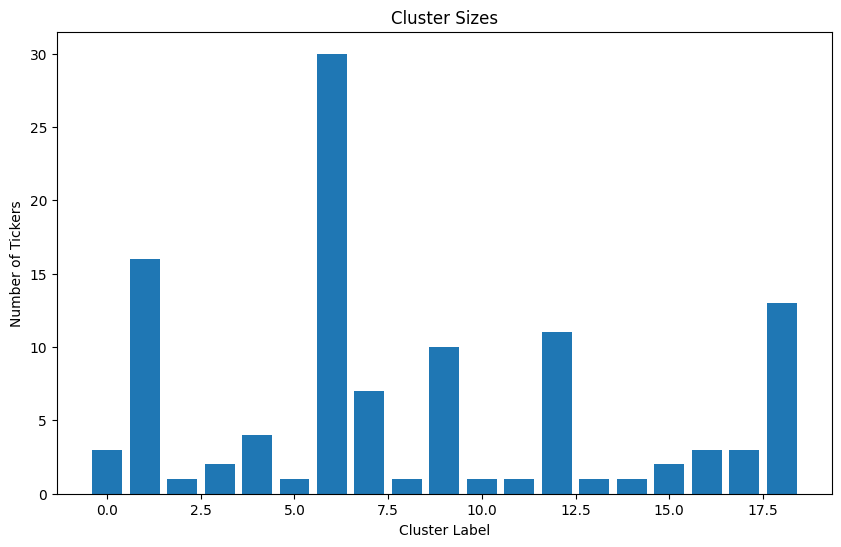

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def visualize_cluster_sizes(df):
    cluster_sizes = df.groupby("cluster_label").size().reset_index(name="cluster_size")
    sorted_cluster_sizes = cluster_sizes.sort_values("cluster_size", ascending=False)

    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_cluster_sizes["cluster_label"], sorted_cluster_sizes["cluster_size"])
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Tickers")
    plt.title("Cluster Sizes")
    plt.show()


visualize_cluster_sizes(dfClustered[["Ticker", "cluster_label"]])


In [ ]:
!pip install squarify

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cluster_distribution(df, ticker_column, cluster_column):
    plt.figure(figsize=(10,6))
    sns.countplot(x=cluster_column, data=df)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Tickers')
    plt.title('Number of Tickers in each Cluster')
    plt.show()
import squarify
import matplotlib.pyplot as plt

def plot_cluster_treemap(df, ticker_column, cluster_column):
    cluster_sizes = df.groupby(cluster_column).size()

    plt.figure(figsize=(12,8))
    squarify.plot(sizes=cluster_sizes, label=cluster_sizes.index, alpha=.8)
    plt.axis('off')
    plt.show()


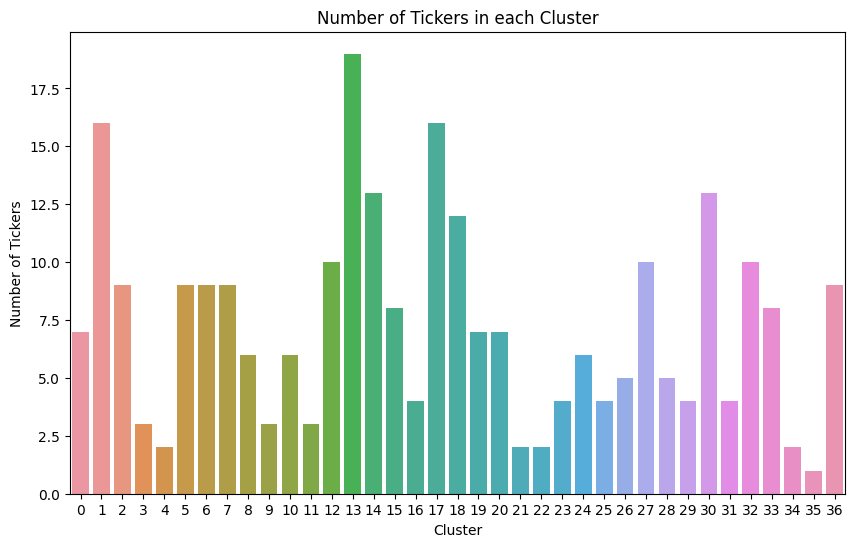

In [ ]:
plot_cluster_distribution(dfClustered, 'Ticker', 'cluster_label')


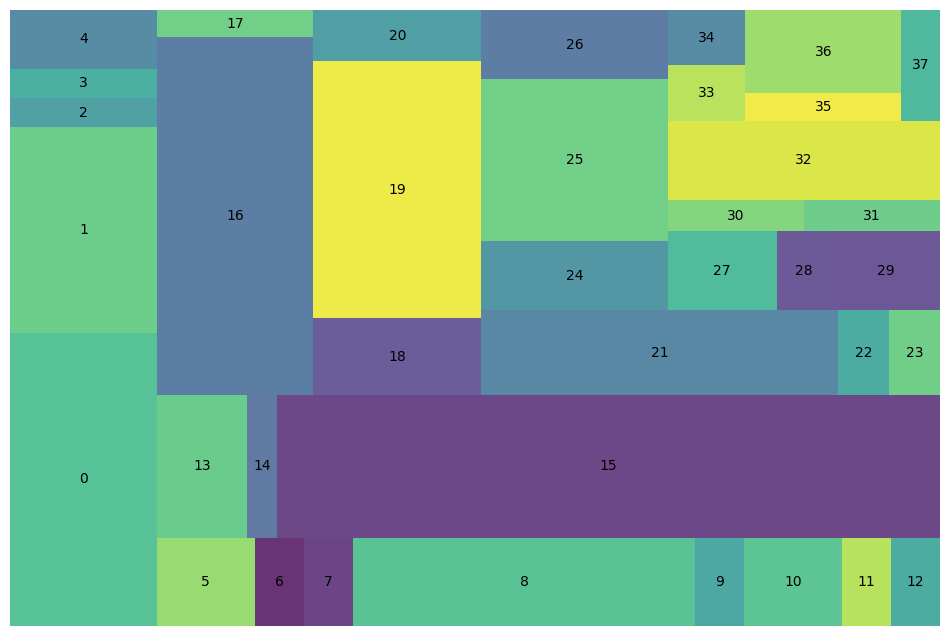

In [ ]:
plot_cluster_treemap(dfClustered, 'Ticker', 'cluster_label')


In [ ]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Function to remove outliers
def remove_outliers(df):
    Q1 = df.quantile(0.04)
    Q3 = df.quantile(0.96)
    IQR = Q3 - Q1
    df_out = df[~((df < (Q1 - 2 * IQR)) | (df > (Q3 + 2 * IQR))).any(axis=1)]
    return df_out

def cluster_data(df):
    # Drop non-numeric columns
    dfNames=df['Ticker']
    df = df.drop(['index', 'Ticker'], axis=1)

    # Handling missing values
    df = df.dropna()

    # Remove outliers
    #df = remove_outliers(df)

    # Function to create the clustering pipeline
    def make_pipeline_kmeans(n_clusters):
        pipeline = make_pipeline(
            StandardScaler(),
            KMeans(n_clusters=n_clusters)
        )
        return pipeline

    # Parameters for KMeans
    kmeans_params = {'kmeans__n_clusters': range(2, 10)}

    # Prepare features
    X = df.values

    # Create and fit model
    kmeans_search = GridSearchCV(make_pipeline_kmeans(2), kmeans_params, cv=5)
    kmeans_search.fit(X)
    df['Ticker']=dfNames
    # Assigning the cluster labels to the original dataframe
    df['cluster_label'] = kmeans_search.predict(X)

    # Print best parameters
    print("Best parameters found: ", kmeans_search.best_params_)

    return df
cluster_data(df)

In [ ]:
import pandas as pd

def combine_dataframes(dataframes):
    if len(dataframes) == 0:
        return None

    combined_df = dataframes[0]
    for i in range(1, len(dataframes)):
        combined_df = pd.concat([combined_df, dataframes[i]], axis=0)

    combined_df.sort_index(inplace=True)  # Sort the combined dataframe by index

    return combined_df

combine_dataframes(ratios_dataframes)

In [ ]:
import pandas as pd

def calculate_percentile_ranges(df_list, start_year, end_year):
    df = pd.concat(df_list)
    df['Year'] = pd.to_datetime(df['Year'])
    df = df[(df['Year'].dt.year >= start_year) & (df['Year'].dt.year <= end_year)]

    percentile_df = pd.DataFrame()
    percentiles = {'Best': 90, 'Above_Average': 75, 'Average': 50, 'Below_Average': 25, 'Worst': 0}

    for name, value in percentiles.items():
        percentile_df[name] = df.quantile(value/100)

    return percentile_df.T

start_year = 2021
end_year = 2022
result = calculate_percentile_ranges(ratios_dataframes, start_year, end_year)
print(result)



KeyError: ignored

In [ ]:
import pandas as pd

def calculate_percentile_ranges(df_list, start_year, end_year):
    # Concatenate the dataframes in the list
    df = pd.concat(df_list)

    # Check if index is not a DatetimeIndex, convert it if necessary
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Filter by the year range
    df = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

    # Calculate the percentiles for each column and store in a new dataframe
    percentile_df = pd.DataFrame()

    percentiles = {'Best': 90, 'Above_Average': 75, 'Average': 50, 'Below_Average': 25, 'Worst': 0}

    for name, value in percentiles.items():
        percentile_df[name] = df.quantile(value/100)

    return percentile_df.T



calculate_percentile_ranges(ratios_dataframes, 2021, 2022)


,PE_Ratio,Debt_to_Equity_Ratio,Current_Ratio,Quick_Ratio,ROE,ROA,Working_Capital_Ratio,Gross_Margin_Ratio,Operating_Margin_Ratio,Cash_Ratio,Inventory_Turnover_Ratio,Accounts_Receivable_Turnover_Ratio,EPS,Asset_Turnover_Ratio,Interest_Coverage_Ratio,Return_on_Investment
Best,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Above_Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Below_Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Worst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def calculate_percentile_ranges(df_list, start_year, end_year):
    # Concatenate the dataframes in the list and filter by the year range
    df = pd.concat(df_list)
    df = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

    # Create a list to store the first rows of each dataframe
    first_rows = []

    for df in df_list:
        # Extract the column names from the first row
        column_names = df.columns.tolist()

        # Add the first row as a new row with column names
        first_row = pd.DataFrame([df.iloc[0]], columns=column_names)
        first_rows.append(first_row)

    # Concatenate the first rows with the percentile dataframe
    percentile_df = pd.concat(first_rows + [df])

    # Calculate the percentiles for each column and store in a new dataframe
    percentiles = {'Best': 90, 'Above_Average': 75, 'Average': 50, 'Below_Average': 25, 'Worst': 0}
    for name, value in percentiles.items():
        percentile_df[name] = df.quantile(value/100)

    return percentile_df.T

calculate_percentile_ranges(ratios_dataframes, 2020, 2022)
calculate_percentile_ranges.info()

AttributeError: ignored

In [ ]:
def calculate_percentile_ranges(df_list, start_year, end_year):
    # Concatenate the dataframes in the list and filter by the year range
    df = pd.concat(df_list)
    df = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

    # Create a list to store the first rows of each dataframe
    first_rows = []

    for df in df_list:
        # Extract the column names from the first row
        column_names = df.columns.tolist()

        # Add the first row as a new row with column names
        first_row = pd.DataFrame([df.iloc[0]], columns=column_names)
        first_rows.append(first_row)

    # Concatenate the first rows with the percentile dataframe
    percentile_df = pd.concat(first_rows + [df])

    # Calculate the percentiles for each column and store in a new dataframe
    percentiles = {'Best': 90, 'Above_Average': 75, 'Average': 50, 'Below_Average': 25, 'Worst': 0}
    for name, value in percentiles.items():
        percentile_df[name] = df.quantile(value/100)

    return percentile_df.T


calculate_percentile_ranges(ratios_dataframes, 2020, 2022)

